In [80]:
import face_recognition
import os
import pickle

# Folder containing subfolders for each person
KNOWN_FACES_DIR = "known_faces"
ENCODINGS_FILE = "encodings.pkl"

all_encodings = {}
all_names = []

# Iterate over each person's folder
for person_name in os.listdir(KNOWN_FACES_DIR):
    person_folder = os.path.join(KNOWN_FACES_DIR, person_name)
    if not os.path.isdir(person_folder):
        continue  # Skip if not a folder

    encodings = []
    for image_name in os.listdir(person_folder):
        # Skip non-image files
        if not image_name.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        image_path = os.path.join(person_folder, image_name)
        try:
            image = face_recognition.load_image_file(image_path)
            face_encs = face_recognition.face_encodings(image)

            if len(face_encs) == 0:
                print(f"⚠️ No face found in {image_path}, skipping.")
                continue

            encodings.append(face_encs[0])
        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
            continue

    if len(encodings) > 0:
        all_encodings[person_name] = encodings
        all_names.append(person_name)
        print(f"✅ {person_name}: {len(encodings)} face(s) encoded.")
    else:
        print(f"⚠️ {person_name} has no valid images. Skipping.")

# Save all encodings to a file
with open(ENCODINGS_FILE, "wb") as f:
    pickle.dump(all_encodings, f)

print(f"\n🎉 All embeddings saved to '{ENCODINGS_FILE}'")
print("Trusted people:", all_names)

⚠️ .ipynb_checkpoints has no valid images. Skipping.
⚠️ No face found in known_faces\IronMan\boss.jpeg, skipping.
⚠️ IronMan has no valid images. Skipping.
✅ Parth: 2 face(s) encoded.

🎉 All embeddings saved to 'encodings.pkl'
Trusted people: ['Parth']


In [85]:
import threading
import win32com.client

speaker = win32com.client.Dispatch("SAPI.SpVoice")

def speak(text):
    def _speak():
        speaker.Speak(text)
        print("🗣️ Guard:", text)
    threading.Thread(target=_speak, daemon=True).start()

# Cell 2
import os
import time
import json
import queue
import threading
import sounddevice as sd
from vosk import Model, KaldiRecognizer
import pyttsx3
import importlib

# -------------------------------
# Config
# -------------------------------
MIC_INDEX = 6
SAMPLERATE = 16000
MODEL_PATH = "vosk-model-small-en-us-0.15"

# Grammar / words (kept exactly as in your original)
GRAMMAR = '["jarvis", "hey jarvis", "okay jarvis","buddy","please","a","an","the", \
            "guard my room", "start guarding", "activate guard mode", "begin monitoring",\
            "never mind", "cancel", "stop", "exit", \
            "please guard my room", "can you guard the room","monitor this room"]'
WAKE_WORDS = ["jarvis", "hey jarvis", "okay jarvis"]
GUARD_COMMANDS = ["guard my room", "guard this room", "activate guard mode",
                  "begin monitoring", "guard the room", "monitor this room", "start guarding"]
CANCEL_COMMANDS = ["never mind", "cancel", "stop", "exit"]

# -------------------------------
# Thread-safe pyttsx3 TTS (engine created inside worker)
# -------------------------------
# def _speak_proc(text):
#     engine = pyttsx3.init()
#     engine.setProperty('rate', 150)
#     engine.say(text)
#     engine.runAndWait()

# def speak(text):
#     p = multiprocessing.Process(target=_speak_proc, args=(text,))
#     print("🗣️ Guard:", text)
#     p.start()
###########################################
# def speak(text):
#     try:
#         # force reload of pyttsx3 each time
#         importlib.reload(pyttsx3)
#         engine = pyttsx3.init()
#         engine.setProperty('rate', 150)
#         engine.say(text)
#         engine.runAndWait()
#         engine.stop()
#         print("🗣️ Guard:", text)
#     except Exception as e:
#         print("TTS error:", e)

#####################################################33
# # Start TTS worker once (if not already started)
# try:
#     # avoid creating multiple threads if re-running cell
#     if not globals().get("_tts_thread") or not globals()["_tts_thread"].is_alive():
#         _tts_thread = threading.Thread(target=_tts_worker, daemon=True)
#         _tts_thread.start()
#         globals()["_tts_thread"] = _tts_thread
# except Exception as e:
#     print("Failed to start TTS thread:", e)

# def speak(text):
#     """Queue message for TTS and also print for debug."""
#     print("🗣️ Guard:", text)
#     tts_queue.put(text)

# -------------------------------
# Vosk listener setup (keeps your original device select and flow)
# -------------------------------
q_audio = queue.Queue()

def _sd_callback(indata, frames, time_info, status):
    if status:
        print("Audio status:", status)
    q_audio.put(bytes(indata))

# set microphone device (will print available devices if index invalid)
try:
    devices = sd.query_devices()
    sd.default.device = MIC_INDEX
    print(f"🎤 Using microphone device {MIC_INDEX}: {devices[MIC_INDEX]['name']}")
except Exception as e:
    print("Warning: microphone device selection failed:", e)

# load model
try:
    model = Model(MODEL_PATH)
    print("✅ Vosk model loaded:", MODEL_PATH)
except Exception as e:
    print("Failed to load Vosk model:", e)
    raise SystemExit

def make_recognizer():
    return KaldiRecognizer(model, SAMPLERATE, GRAMMAR)

# global recognizer for wake-word loop
rec = make_recognizer()

def listen_for_wake_word(speak_fn=None):
    """
    Blocks until:
      - returns True when guard command detected (start guard mode)
      - returns False if cancelled to standby
      - returns None on interruption/error
    Uses separate recognizer for the inner command loop (rec_cmd) so we don't shadow 'rec'.
    """
    print("🎧 Listening for wake word ('jarvis')...")
    try:
        with sd.RawInputStream(samplerate=SAMPLERATE, blocksize=8000,
                               dtype='int16', channels=1, callback=_sd_callback):
            while True:
                data = q_audio.get()
                if rec.AcceptWaveform(data):
                    result = json.loads(rec.Result())
                    text = result.get("text", "").lower().strip()
                    if not text:
                        continue
                    print("🗣️ Heard:", repr(text))
                    if any(w in text for w in WAKE_WORDS):
                        # Speak the prompt (use provided speak function)
                        if speak_fn:
                            speak_fn("Yes boss?")
                        # create separate recognizer for commands
                        rec_cmd = make_recognizer()
                        while True:
                            data_cmd = q_audio.get()
                            if rec_cmd.AcceptWaveform(data_cmd):
                                cmd_result = json.loads(rec_cmd.Result())
                                cmd_text = cmd_result.get("text", "").lower().strip()
                                if not cmd_text:
                                    continue
                                print("🎙️ Detected Command:", repr(cmd_text))
                                if any(c in cmd_text for c in GUARD_COMMANDS):
                                    if speak_fn: speak_fn("Activating guard mode now.")
                                    return True
                                if any(c in cmd_text for c in CANCEL_COMMANDS):
                                    print("🔴 Cancel command received. Returning to standby.")
                                    if speak_fn: speak_fn("Okay, standing by.")
                                    break  # back to outer wake-word listen
                                # other/unmatched command — prompt again
                                print("⚠️ Command not understood. Waiting again...")
                                if speak_fn: speak_fn("I didn't understand, please repeat.")
    except KeyboardInterrupt:
        print("Listen interrupted by user.")
        return None
    except Exception as e:
        print("Listen error:", e)
        return None

🎤 Using microphone device 6: Microphone Array (Realtek(R) Audio)
✅ Vosk model loaded: vosk-model-small-en-us-0.15


In [86]:
# Cell 3
import cv2
import mediapipe as mp
import face_recognition
import numpy as np
import os
import math
import time

# reuse configs from cell 1 scope (KNOWN_FACES_DIR, FACE_SIZE, etc.)
KNOWN_FACES_DIR = "known_faces"
FACE_SIZE = (100, 100)
TOLERANCE = 0.6
RECOGNITION_INTERVAL = 8
MATCH_DIST_THRESH = 100
TRACKER_MAX_MISSES = 30

# Unknown handling parameters
UNKNOWN_THRESHOLD = 8      # frames to consider "still present"
LEVEL_COOLDOWN = 3         # seconds between escalation speech
RE_GREET_DELAY = 600        # seconds before rehearing same person

# -------------------------------
# Load known embeddings (unchanged)
# -------------------------------
known_embeddings = {}
for person_name in os.listdir(KNOWN_FACES_DIR):
    person_dir = os.path.join(KNOWN_FACES_DIR, person_name)
    if not os.path.isdir(person_dir):
        continue
    embeddings = []
    for file in os.listdir(person_dir):
        if file.lower().endswith(".npy"):
            emb_path = os.path.join(person_dir, file)
            try:
                emb = np.load(emb_path)
                embeddings.append(emb)
            except Exception as e:
                print("Failed to load", emb_path, e)
    if embeddings:
        known_embeddings[person_name] = embeddings

print(f"Loaded embeddings for: {list(known_embeddings.keys())}")

# -------------------------------
# Tracker state & helpers
# -------------------------------
tracked_faces = []
next_track_id = 0

def align_face(face_img):
    landmarks_list = face_recognition.face_landmarks(face_img)
    if not landmarks_list:
        return face_img
    landmarks = landmarks_list[0]
    left_eye = np.mean(landmarks['left_eye'], axis=0)
    right_eye = np.mean(landmarks['right_eye'], axis=0)
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))
    h, w = face_img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    aligned = cv2.warpAffine(face_img, M, (w, h))
    return aligned

def centroid_of_bbox(x1, y1, x2, y2):
    return ((x1 + x2) // 2, (y1 + y2) // 2)

def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def match_detections_to_tracks(detections):
    """
    detections: list of dicts {'bbox':(x,y,x2,y2), 'centroid':(cx,cy), 'name': None or str}
    Updates tracked_faces in-place, returns mapping detection_index -> track index
    Each track contains:
      'id','centroid','name','misses','intruder_level','last_spoken','present_frames'
    """
    global tracked_faces, next_track_id
    mapping = {}

    if len(tracked_faces) == 0:
        for i, det in enumerate(detections):
            tracked_faces.append({
                'id': next_track_id,
                'centroid': det['centroid'],
                'name': det.get('name', "Unknown"),
                'misses': 0,
                'intruder_level': 0,
                'last_spoken': 0.0,
                'present_frames': 1
            })
            mapping[i] = len(tracked_faces) - 1
            next_track_id += 1
        return mapping

    used_tracks = set()
    for i, det in enumerate(detections):
        best_idx, best_dist = None, float("inf")
        for ti, track in enumerate(tracked_faces):
            d = dist(det['centroid'], track['centroid'])
            if d < best_dist:
                best_dist = d
                best_idx = ti
        if best_idx is not None and best_dist <= MATCH_DIST_THRESH and best_idx not in used_tracks:
            mapping[i] = best_idx
            used_tracks.add(best_idx)
            # update track
            tracked_faces[best_idx]['centroid'] = det['centroid']
            tracked_faces[best_idx]['misses'] = 0
            tracked_faces[best_idx]['present_frames'] += 1
            if det.get('name'):
                # if recognized, update name and reset intruder counters
                tracked_faces[best_idx]['name'] = det['name']
                tracked_faces[best_idx]['intruder_level'] = 0
                tracked_faces[best_idx]['last_spoken'] = 0.0
        else:
            tracked_faces.append({
                'id': next_track_id,
                'centroid': det['centroid'],
                'name': det.get('name', "Unknown"),
                'misses': 0,
                'intruder_level': 0,
                'last_spoken': 0.0,
                'present_frames': 1
            })
            mapping[i] = len(tracked_faces) - 1
            next_track_id += 1

    # increment misses for tracks not matched this frame
    for ti, track in enumerate(tracked_faces):
        if ti not in used_tracks and ti not in mapping.values():
            tracked_faces[ti]['misses'] += 1
            tracked_faces[ti]['present_frames'] = 0

    # remove stale tracks (also clear greeted entries externally if needed)
    tracked_faces = [t for t in tracked_faces if t['misses'] <= TRACKER_MAX_MISSES]

    return mapping

Loaded embeddings for: ['IronMan', 'Parth']


In [88]:
# -------------------------------
# Cell 4 – Guard Mode: Robust Names, Flicker Tolerance & Single Unknown Handler
# -------------------------------
import time
import threading
import queue
import json
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from vosk import KaldiRecognizer

# Config (tweak if needed)
PASSWORD = "ironman is awesome"
MAX_PASSWORD_ATTEMPTS = 3
MAX_YESNO_ATTEMPTS = 3
YESNO_TIMEOUT = 6
PASSWORD_TIMEOUT = 6
LEAVE_TIMER = 6
FLICKER_TOLERANCE = 10        # frames required to consider a detection stable (avoid flicker)
RECOGNITION_INTERVAL = 6      # how often (frames) to run face recognition
RE_GREET_DELAY = 600          # seconds before greeting same person again
FACE_SIZE = (150, 150)
TOLERANCE = 0.6               # face_recognition tolerance

# Focused small vocab grammars for reliability
YES_NO_VOCAB = ["yes","yeah","yep","affirmative","sure","correct","no","nope","negative","nah"]
PASSWORD_VOCAB = [PASSWORD]
VOCAB = ["yes","yeah","yep","affirmative","sure","correct",
         "no","nope","negative","nah","ironman","is","awesome","ironman is awesome"]

# Threading primitives
audio_lock = threading.Lock()
unknown_handler_lock = threading.Lock()

# Helper: blocking TTS
def speak_and_wait(text, delay_after=0.1):
    global speaker
    print("🗣️ Guard:", text)
    speaker.Speak(text)
    time.sleep(delay_after)

# Helper: listen for expected words
def listen_for_expected(expected_words, timeout):
    recognized_text = ""
    with audio_lock:
        local_q = queue.Queue()

        def audio_callback(indata, frames, time_info, status):
            if status:
                print("Audio status:", status)
            local_q.put(bytes(indata))

        grammar = json.dumps(expected_words)

        with sd.RawInputStream(samplerate=16000, blocksize=8000,
                               dtype='int16', channels=1,
                               callback=audio_callback):
            rec = KaldiRecognizer(model, 16000, grammar)
            start = time.time()
            while time.time() - start < timeout:
                try:
                    data = local_q.get(timeout=0.3)
                except queue.Empty:
                    continue

                if rec.AcceptWaveform(data):
                    res = json.loads(rec.Result())
                    text = res.get("text", "").lower().strip()
                else:
                    try:
                        pres = json.loads(rec.PartialResult())
                        text = pres.get("partial", "").lower().strip()
                    except Exception:
                        text = ""

                if not text:
                    continue

                recognized_text += " " + text
                tokens = text.split()
                for w in expected_words:
                    if w.lower() in tokens or w.lower() in recognized_text.lower():
                        return w.lower()

    print(f"[DEBUG listen] No match in '{recognized_text.strip()}'")
    return None

# Threaded unknown handler
def handle_unknown(track, snapshot):
    """Handle an unknown person with flicker tolerance and robust password."""
    if not unknown_handler_lock.acquire(blocking=False):
        print("[INFO] Another unknown currently handled, skipping this one.")
        track['handled'] = False
        return

    try:
        print(f"[INFO] Starting handler for track id={track.get('id')}")
        time.sleep(0.15)

        # Flicker stability check
        stable_ok = track.get('present_frames', 0) >= FLICKER_TOLERANCE
        if not stable_ok:
            wait_start = time.time()
            while time.time() - wait_start < 2.0:
                if track.get('present_frames', 0) >= FLICKER_TOLERANCE:
                    stable_ok = True
                    break
                time.sleep(0.1)
        if not stable_ok:
            print(f"[INFO] Track {track.get('id')} not stable, aborting handler.")
            track['handled'] = False
            return

        absent_frames = 0

        # --- YES/NO loop ---
        yesno_answer = None
        for attempt in range(MAX_YESNO_ATTEMPTS):
            if not track.get('present_frames', 0):
                absent_frames += 1
                if absent_frames >= FLICKER_TOLERANCE:
                    print(f"[INFO] Track {track.get('id')} disappeared during yes/no.")
                    track['handled'] = False
                    return

            speak_and_wait("Are you authorised in this room? Yes or No?")
            ans = listen_for_expected(YES_NO_VOCAB, YESNO_TIMEOUT)
            if ans:
                tok = ans.lower()
                if tok in ("yes","yeah","yep","affirmative","sure","correct"):
                    yesno_answer = "yes"
                elif tok in ("no","nope","negative","nah"):
                    yesno_answer = "no"
                break
            elif attempt < MAX_YESNO_ATTEMPTS - 1:
                speak_and_wait("No clear response. Please answer yes or no.")
                time.sleep(0.05)

        if yesno_answer != "yes":
            speak_and_wait("Not registered in database, please leave immediately.")
            try:
                fname = f"intruder_{track['id']}_{int(time.time())}.png"
                cv2.imwrite(fname, snapshot)
                snap512 = cv2.resize(snapshot, (512,512))
                plt.figure(figsize=(4,4))
                plt.imshow(cv2.cvtColor(snap512, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
            except Exception as e:
                print("Snapshot error:", e)
            track['snapshot_taken'] = True
            track['leave_timer_start'] = time.time()
            track['handled'] = True
            return

        # --- PASSWORD loop ---
        correct = False
        for p_try in range(MAX_PASSWORD_ATTEMPTS):
            if not track.get('present_frames', 0):
                absent_frames += 1
                if absent_frames >= FLICKER_TOLERANCE:
                    print(f"[INFO] Track {track.get('id')} disappeared during password.")
                    track['handled'] = False
                    return

            speak_and_wait("Please say the password.")
            pwd = listen_for_expected(PASSWORD_VOCAB, PASSWORD_TIMEOUT)
            print(f"[DEBUG] Heard password phrase: {pwd}")
            if pwd and PASSWORD.lower() in pwd.lower():
                correct = True
                break
            elif p_try < MAX_PASSWORD_ATTEMPTS - 1:
                speak_and_wait("Wrong password. Try again.")

        if correct:
            speak_and_wait("Access granted. You may stay.")
            track['allowed'] = True
            track['state'] = 'allowed'

            # Assign sequential Unknown_i label
            enc = track.get('encoding')
            if enc is not None:
                next_id = len([n for n in known_embeddings if n.lower().startswith('unknown_')]) + 1
                new_name = f"Unknown_{next_id}"
                known_embeddings[new_name] = [enc]
                track['name'] = new_name
            track['handled'] = True
            return
        else:
            speak_and_wait("Incorrect password. Please leave immediately.")
            try:
                fname = f"intruder_{track['id']}_{int(time.time())}.png"
                cv2.imwrite(fname, snapshot)
                snap512 = cv2.resize(snapshot, (512,512))
                plt.figure(figsize=(4,4))
                plt.imshow(cv2.cvtColor(snap512, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
            except Exception as e:
                print("Snapshot error:", e)
            track['snapshot_taken'] = True
            track['leave_timer_start'] = time.time()
            track['handled'] = True
            return

    finally:
        unknown_handler_lock.release()
        print(f"[INFO] Handler finished for track id={track.get('id')}")

# -------------------------------
# Main guard mode function
# -------------------------------
def start_guard_mode():
    global tracked_faces, known_embeddings, model

    mp_face_detection = mp.solutions.face_detection
    cap = cv2.VideoCapture(0)

    speak_and_wait("Please wait.")
    for _ in range(5): cap.read()
    speak_and_wait("Guard mode active. Monitoring initiated.")

    frame_count = 0
    greeted = {}
    # time.sleep(5)

    with mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.9) as face_detection:
        while True:
            ret, frame = cap.read()
            if not ret: continue

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_detection.process(rgb)
            detections = []

            if results.detections:
                for d in results.detections:
                    bboxC = d.location_data.relative_bounding_box
                    h, w, _ = frame.shape
                    x = max(0, int(bboxC.xmin * w))
                    y = max(0, int(bboxC.ymin * h))
                    w_box = min(int(bboxC.width * w), w - x)
                    h_box = min(int(bboxC.height * h), h - y)
                    x2, y2 = x + w_box, y + h_box
                    cx, cy = (x + x2)//2, (y + y2)//2
                    detections.append({'bbox':(x,y,x2,y2), 'centroid':(cx,cy), 'name': None})

                    if frame_count % RECOGNITION_INTERVAL == 0 and detections:
                        for det in detections:
                            x,y,x2,y2 = det['bbox']
                            face_crop = rgb[y:y2, x:x2]
                            if face_crop.size == 0 or face_crop.shape[0] < 30 or face_crop.shape[1] < 30:
                                det['name'] = "Unknown"
                                continue
                            face_al = align_face(face_crop)
                            face_al = cv2.resize(face_al, FACE_SIZE)
                            encs = face_recognition.face_encodings(face_al)
                            if not encs:
                                encs = face_recognition.face_encodings(face_al,
                                            known_face_locations=[(0, face_al.shape[0], face_al.shape[1], 0)])
                            # If no encodings, mark Unknown
                            if not encs:
                                det['name'] = "Unknown"
                                continue
                    
                            fe = encs[0]
                            det['encoding'] = fe
                    
                            # Only match against known embeddings if track is not yet marked Unknown
                            if det.get('name') != "Unknown":
                                matched = False
                                for person_name, emb_list in known_embeddings.items():
                                    if any(face_recognition.compare_faces(emb_list, fe, tolerance=TOLERANCE)):
                                        det['name'] = person_name
                                        matched = True
                                        break
                                if not matched:
                                    det['name'] = "Unknown"
                            else:
                                det['name'] = "Unknown"


            mapping = match_detections_to_tracks(detections)
            now = time.time()

            for t in tracked_faces:
                t['current_in_frame'] = False

            for i, det in enumerate(detections):
                track_idx = mapping.get(i)
                if track_idx is None or track_idx >= len(tracked_faces):
                    continue
                track = tracked_faces[track_idx]

                if 'encoding' in det:
                    track['encoding'] = det['encoding']
                if det.get('name') and det['name'] != "Unknown":
                    track['name'] = det['name']

                name = track.get('name') or "Unknown"
                track['name'] = name
                track['current_in_frame'] = True

                x,y,x2,y2 = det['bbox']
                color = (0,0,255) if (name == "Unknown" and not track.get('allowed', False)) else (0,255,0)
                cv2.rectangle(frame, (x,y), (x2,y2), color, 2)
                cv2.putText(frame, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

                if name != "Unknown":
                    last = greeted.get(name, 0)
                    if now - last > RE_GREET_DELAY:
                        speak_and_wait(f"Hello {name}. Welcome.")
                        greeted[name] = now

                # if name == "Unknown":
                #     if track.get('present_frames', 0) >= FLICKER_TOLERANCE and not track.get('handled', False):
                #         if unknown_handler_lock.acquire(blocking=False):
                #             unknown_handler_lock.release()
                #             track['handled'] = True
                #             snapshot = frame[y:y2, x:x2].copy()
                #             threading.Thread(target=handle_unknown, args=(track, snapshot), daemon=True).start()
                if name == "Unknown":
                        if track.get('present_frames', 0) >= FLICKER_TOLERANCE and not track.get('handled', False):
                            if unknown_handler_lock.acquire(blocking=False):
                                unknown_handler_lock.release()
                                track['handled'] = True
                                snapshot = frame[y:y2, x:x2].copy()
                                threading.Thread(target=handle_unknown, args=(track, snapshot), daemon=True).start()
                    
                        # --- Intruder alert if they remain after LEAVE_TIMER ---
                        if track.get('leave_timer_start'):
                            elapsed = now - track['leave_timer_start']
                            if elapsed >= LEAVE_TIMER and not track.get('alerted', False):
                                speak_and_wait("Intruder still present! Calling police.")
                                track['alerted'] = True


            frame_count += 1
            cv2.imshow("Guard Mode", frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    speak_and_wait("Guard mode deactivated.")

🎧 Listening for wake word ('jarvis')...
🗣️ Guard: System started.
🗣️ Heard: 'jarvis buddy'
🗣️ Guard: Yes boss?
🎙️ Detected Command: 'activate guard mode'
🗣️ Guard: Activating guard mode now.
🗣️ Guard: Please wait.
🗣️ Guard: Guard mode active. Monitoring initiated.
🗣️ Guard: Hello Parth. Welcome.
🗣️ Guard: Hello IronMan. Welcome.
[INFO] Starting handler for track id=3
🗣️ Guard: Are you authorised in this room? Yes or No?
🗣️ Guard: Please say the password.
[DEBUG] Heard password phrase: ironman is awesome
🗣️ Guard: Access granted. You may stay.
[INFO] Handler finished for track id=3
🗣️ Guard: Hello Unknown_1. Welcome.
[INFO] Starting handler for track id=5
🗣️ Guard: Are you authorised in this room? Yes or No?
🗣️ Guard: Please say the password.
[DEBUG listen] No match in 'ironman ironman is ironman is ironman'
[DEBUG] Heard password phrase: None
🗣️ Guard: Wrong password. Try again.
🗣️ Guard: Please say the password.
[DEBUG listen] No match in ''
[DEBUG] Heard password phrase: None
🗣️ Guar

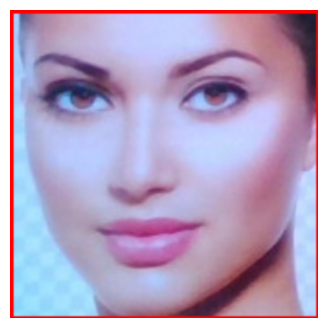

[INFO] Handler finished for track id=5
🗣️ Guard: Intruder still present! Calling police.
🗣️ Guard: Guard mode deactivated.
🎧 Listening for wake word ('jarvis')...
🗣️ Guard: Waiting for next command.
🗣️ Heard: 'an guard an start buddy exit hey jarvis a begin'
🗣️ Guard: Yes boss?
🎙️ Detected Command: 'an you okay an a can buddy begin'
⚠️ Command not understood. Waiting again...
🎙️ Detected Command: 'start guard mode'
⚠️ Command not understood. Waiting again...
🗣️ Guard: I didn't understand, please repeat.
🗣️ Guard: I didn't understand, please repeat.
🎙️ Detected Command: 'please monitor this room'
🗣️ Guard: Activating guard mode now.
🗣️ Guard: Please wait.
🗣️ Guard: Guard mode active. Monitoring initiated.
🗣️ Guard: Hello Parth. Welcome.
🗣️ Guard: Hello IronMan. Welcome.
🗣️ Guard: Guard mode deactivated.
🎧 Listening for wake word ('jarvis')...
🗣️ Guard: Waiting for next command.
Listen interrupted by user.
Listener stopped.


In [89]:
# final cell
if __name__ == "__main__":
    try:
        speak("System started.")
        while True:
            act = listen_for_wake_word(speak_fn=speak)
            if act is True:
                # guard command recognized
                start_guard_mode()
                speak("Waiting for next command.")
            elif act is None:
                # listener interrupted or error - exit loop
                print("Listener stopped.")
                break
            else:
                # act == False / standby or cancelled -> keep listening
                continue
    except KeyboardInterrupt:
        print("Interrupted by user.")
    finally:
        # clean shutdown of TTS worker (optional)
        try:
            tts_queue.put(None)
        except Exception:
            pass